### CAM

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_input_rn50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K
import cv2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mbnv2
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input as pre


2021-12-07 06:33:30.290603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 06:33:30.290625: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def preprocess_img(preprocess_input, shape=(224,224), img_path='collies.JPG'):
    img = image.load_img(img_path, target_size=shape)
    x = image.img_to_array(img)
    np_x = x.copy()
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x, np_x.astype(np.uint8)

In [3]:
img_path = 'water-bird.JPEG'
img = image.load_img(img_path, target_size=(224, 224))
np_img=np.array(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input_rn50(x)

In [4]:
# base_model_mbnv2 = MobileNetV2(weights="imagenet")
base_model_rn50 = ResNet50(weights="imagenet")
# base_model_vgg19 = VGG19(weights="imagenet")
# base_model_enb3 = EfficientNetB3(weights="imagenet")

2021-12-07 06:33:31.818154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sudarshan/Documents/Mobile Robotics/SMAI_project/SMAI/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 06:33:31.818176: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-07 06:33:31.818193: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sudarshan): /proc/driver/nvidia/version does not exist
2021-12-07 06:33:31.818330: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable t

In [5]:
def get_ConvFeatureANDWeights(base_model,last_conv_layer_name,input_x):
    model = Model(inputs=base_model.input, outputs=[base_model.get_layer(last_conv_layer_name).output,base_model.layers[-1].output])
    conv_features,prediction = model.predict(input_x)
    conv_features=np.squeeze(conv_features)

    weights_all = model.layers[-1].get_weights()[0] # 0 for weights, 1 for biases
    class_specific_weight = weights_all[:,np.argmax(prediction)]

    return conv_features, class_specific_weight

def compute_CAM(conv_features, class_specific_weight):  
    cam = np.zeros(shape=conv_features.shape)
    cam = np.sum((class_specific_weight*conv_features),axis=-1)
    # cam = np.max(cam,0)
    cam /= np.max(cam)

    return cam

def get_CAM(model, last_conv_layer_name, input_x):
    conv_features, class_specific_weight = get_ConvFeatureANDWeights(model, last_conv_layer_name, input_x)
    cam = compute_CAM(conv_features, class_specific_weight)

    return cam

##########################

def get_CAM_Visualization(cam, image, kind='dark', cam_threshold=0.25):
    cam = cv2.resize(cam, image.shape[:2])

    if kind=='dark':
        image = image.astype(np.float16)
        image/=image.max()
        img_loc = image*np.expand_dims(cam,axis=-1)
        img_loc/=img_loc.max()

    else:
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < cam_threshold)] = 0
        img_loc = cv2.addWeighted(heatmap,0.4, image,0.6,0)

    return img_loc

def get_CAM_heatmaps(model, last_conv_layer_name, input_x, image):
    cam = get_CAM(model, last_conv_layer_name, input_x)
    cam = cv2.resize(cam, image.shape[:2])
    return cam

def Visualize_CAM(model, last_conv_layer_name, input_x, image):
    cam = get_CAM(model, last_conv_layer_name, input_x)
    img = get_CAM_Visualization(cam, image)

    return img

In [6]:
# imgCAM1 = Visualize_CAM(base_model_mbnv2, 'Conv_1_bn', x, np_img)
imgCAM2 = Visualize_CAM(base_model_rn50, 'conv5_block3_out', x, np_img)

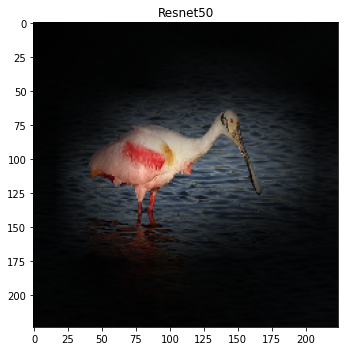

In [7]:
plt.figure(figsize=(12,10))
plt.subplot(121)
# plt.title('MobileNetV2')
# plt.imshow(imgCAM1)
# plt.subplot(122)
plt.title('Resnet50')
plt.imshow(imgCAM2)